In [1]:
import time
import pickle
import numpy as np
import pandas as pd
import os
import torch.optim
import matplotlib.pyplot as plt
from scipy.stats import zscore, rankdata

In [2]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
MIMICtable = pd.read_csv('/content/drive/MyDrive/Capstone/MIMICtable.csv')

In [4]:
MIMICtable.columns

Index(['bloc', 'icustayid', 'charttime', 'gender', 'age', 'elixhauser',
       're_admission', 'presumed_onset', 'died_in_hosp',
       'died_within_48h_of_out_time', 'mortality_90d',
       'delay_end_of_record_and_discharge_or_death', 'Weight_kg', 'GCS', 'HR',
       'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2', 'Temp_C', 'FiO2_1',
       'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN', 'Creatinine',
       'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT', 'SGPT',
       'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count', 'PTT',
       'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE', 'HCO3',
       'Arterial_lactate', 'mechvent', 'Shock_Index', 'PaO2_FiO2',
       'median_dose_vaso', 'max_dose_vaso', 'input_total', 'input_4hourly',
       'output_total', 'output_4hourly', 'cumulated_balance', 'SOFA', 'SIRS'],
      dtype='object')

In [ ]:
MIMICtable

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,presumed_onset,died_in_hosp,died_within_48h_of_out_time,...,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS
0,1.0,200003.0,7.245486e+09,0.0,17639.826435,0.0,0.0,7.245590e+09,0.0,0.0,...,233.333333,0.0,0.0,6527.000,50.0,13617.0,520.0,-7090.000,3.0,1
1,2.0,200003.0,7.245500e+09,0.0,17639.826435,0.0,0.0,7.245590e+09,0.0,0.0,...,210.000000,0.0,0.0,6577.000,50.0,13982.0,365.0,-7405.000,5.0,2
2,3.0,200003.0,7.245515e+09,0.0,17639.826435,0.0,0.0,7.245590e+09,0.0,0.0,...,210.000000,0.0,0.0,6627.000,50.0,14262.0,280.0,-7635.000,5.0,2
3,4.0,200003.0,7.245529e+09,0.0,17639.826435,0.0,0.0,7.245590e+09,0.0,0.0,...,168.000000,0.0,0.0,6677.000,50.0,14602.0,340.0,-7925.000,6.0,1
4,5.0,200003.0,7.245544e+09,0.0,17639.826435,0.0,0.0,7.245590e+09,0.0,0.0,...,1023.500000,0.0,0.0,6727.000,50.0,15142.0,540.0,-8415.000,3.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247396,9.0,299995.0,4.612907e+09,0.0,8538.739340,0.0,0.0,4.612883e+09,0.0,0.0,...,433.333333,0.0,0.0,2633.583,0.0,7010.0,700.0,-4376.417,2.0,2
247397,10.0,299995.0,4.612921e+09,0.0,8538.739340,0.0,0.0,4.612883e+09,0.0,0.0,...,1885.714286,0.0,0.0,2633.583,0.0,7430.0,420.0,-4796.417,0.0,1
247398,11.0,299995.0,4.612936e+09,0.0,8538.739340,0.0,0.0,4.612883e+09,0.0,0.0,...,1885.714286,0.0,0.0,2633.583,0.0,7430.0,0.0,-4796.417,4.0,1
247399,12.0,299995.0,4.612950e+09,0.0,8538.739340,0.0,0.0,4.612883e+09,0.0,0.0,...,366.666667,0.0,0.0,2633.583,0.0,7950.0,520.0,-5316.417,1.0,2


In [5]:
num_epoch = 50  # 训练循环次数
gamma = 0.99
beat1 = 0
beat2 = 0.6
beta3 = 0.3
ncv = 5  # nr of crossvalidation runs (each is 80% training / 20% test)交叉验证运行的Nr(每次为80%训练/ 20%测试)
nra = 5
lr = 1e-5
reward_value = 24
beta = [beat1, beat2, beta3]
icustayidlist = MIMICtable['icustayid']
icuuniqueids = np.unique(icustayidlist)  # list of unique icustayids from MIMIC唯一的icustayid列表
reformat5 = MIMICtable.values.copy()
print('####  生成状态  ####')

# -----------------------筛选后的特征=37个--------------------------------
colnorm = ['SOFA', 'age', 'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'Temp_C',
           'Sodium', 'Chloride', 'Glucose', 'Calcium', 'Hb', 'WBC_count', 'Platelets_count',
           'PTT', 'PT', 'Arterial_pH', 'paO2', 'paCO2', 'HCO3', 'Arterial_lactate', 'Shock_Index',
           'PaO2_FiO2', 'cumulated_balance', 'CO2_mEqL', 'Ionised_Ca']
##8个指标
collog = ['SpO2', 'BUN', 'Creatinine', 'SGOT', 'Total_bili', 'INR', 'input_total', 'output_total']

colnorm = np.where(np.isin(MIMICtable.columns, colnorm))[0]
collog = np.where(np.isin(MIMICtable.columns, collog))[0]

####  生成状态  ####


In [ ]:
colnorm

array([ 4, 12, 13, 14, 15, 16, 17, 18, 20, 23, 24, 25, 29, 30, 31, 36, 37,
       38, 39, 40, 42, 43, 44, 46, 47, 49, 50, 57, 58])

In [ ]:
collog

array([19, 26, 27, 32, 34, 41, 53, 55])

In [ ]:
# reformat5 is a numpy array with MIMItable's value
print(reformat5.shape)

(247401, 60)


In [ ]:
# Check if there are NaN of reformat5
print(np.isnan(reformat5).any())

False


In [6]:
train = np.load('/content/drive/MyDrive/Capstone/dataset/train.npy')
validat = np.load('/content/drive/MyDrive/Capstone/dataset/validation.npy')
test = np.load('/content/drive/MyDrive/Capstone/dataset/test.npy')

In [7]:
scaleMIMIC = np.concatenate([zscore(reformat5[:, colnorm], ddof=1),
                              zscore(np.log(0.1 + reformat5[:, collog]), ddof=1)], axis=1)

In [8]:
Xvalidat = scaleMIMIC[validat, :]
blocsvalidat = reformat5[validat, 0]
ptidvalidat = reformat5[validat, 1]

Xtrain = scaleMIMIC[train, :]
Xtest = scaleMIMIC[test, :]
blocstrain = reformat5[train, 0]  # 序列号
bloctest = reformat5[test, 0]
ptidtrain = reformat5[train, 1]  # 患者编号
ptidtest = reformat5[test, 1]

# *************************
RNNstate = Xtrain  # ***

print('####  生成动作  ####')
nact = nra * nra  # 5*5=25
iol = MIMICtable.columns.get_loc('input_4hourly')  # 输入的列
vcl = MIMICtable.columns.get_loc('max_dose_vaso')  # 最大使用加压药量的列

a = reformat5[:, iol].copy()  # IV fluid  静脉输液复苏
a = rankdata(a[a > 0]) / a[a > 0].shape[0]  # excludes zero fluid (will be action 1)不包括零液体 将是动作1
iof = np.floor((a + 0.2499999999) * 4)  # converts iv volume in 4 actions 在4个动作中转换静脉输液量
a = reformat5[:, iol].copy()
a = np.where(a > 0)[0]  # location of non-zero fluid in big matrix
io = np.ones((reformat5.shape[0], 1))  # array of ones, by default
io[a] = (iof + 1).reshape(-1, 1)  # where more than zero fluid given: save actual action
io = io.ravel()  # 两者的本质都是想把多维的数组降为1维  注射有5个动作，已经通过秩进行判断

vc = reformat5[:, vcl].copy()
vcr = rankdata(vc[vc != 0]) / vc[vc != 0].size
vcr = np.floor((vcr + 0.249999999999) * 4)  # converts to 4 bins
vcr[vcr == 0] = 1
vc[vc != 0] = vcr + 1
vc[vc == 0] = 1

ma1 = np.array(
    [np.median(reformat5[io == 1, iol]), np.median(reformat5[io == 2, iol]), np.median(reformat5[io == 3, iol]),
        np.median(reformat5[io == 4, iol]), np.median(reformat5[io == 5, iol])])  # median dose of drug in all bins
ma2 = np.array(
    [np.median(reformat5[vc == 1, vcl]), np.median(reformat5[vc == 2, vcl]), np.median(reformat5[vc == 3, vcl]),
        np.median(reformat5[vc == 4, vcl]), np.median(reformat5[vc == 5, vcl])])

med = np.concatenate([io.reshape(-1, 1), vc.reshape(-1, 1)], axis=1)
uniqueValues, actionbloc = np.unique(med, axis=0, return_inverse=True)

actionbloctrain = actionbloc[train]  # ***
actionblocvalidat = actionbloc[validat]  # ***
actionbloctest = actionbloc[test]

ma2Values = ma2[uniqueValues[:, 1].astype('int64') - 1].reshape(-1, 1)
ma1Values = ma1[uniqueValues[:, 0].astype('int64') - 1].reshape(-1, 1)
uniqueValuesdose = np.concatenate([ma2Values, ma1Values], axis=1)  # median dose of each bin for all 25 actions
print('####  生成动作完成  ####')

####  生成动作  ####
####  生成动作完成  ####


In [9]:
outcome = 9
Y90 = reformat5[train, outcome]
r = np.array([reward_value, -reward_value]).reshape(1, -1)
r2 = r * (2 * (1 - Y90.reshape(-1, 1)) - 1)

# -----奖励函数准备-----------------------------
SOFA = reformat5[train, 57]  # ***
R3 = r2[:, 0]
R4 = (R3 + reward_value) / (2 * reward_value)
c = 0
bloc_max = max(blocstrain)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [11]:
print(RNNstate.shape[0])
print('#### 生成轨迹 ####')

statesize = RNNstate.shape[1]
states = np.zeros((int(RNNstate.shape[0] * 1.2), statesize))
actions = np.zeros((int(RNNstate.shape[0] * 1.2), 1), dtype=int)
next_actions = np.zeros((int(RNNstate.shape[0] * 1.2), 1), dtype=int)
rewards = np.zeros((int(RNNstate.shape[0] * 1.2), 1))
next_states = np.zeros((int(RNNstate.shape[0] * 1.2), statesize))
done_flags = np.zeros((int(RNNstate.shape[0] * 1.2), 1))
bloc_num = np.zeros((int(RNNstate.shape[0] * 1.2), 1))
blocnum1 = 1

c = 0
bloc_num_reward = 0

for i in range(RNNstate.shape[0] - 1):
    states[c] = RNNstate[i, :]
    actions[c] = actionbloctrain[i]
    bloc_num[c] = blocnum1

    if blocstrain[i] != blocstrain[i + 1]:
        next_states1 = np.zeros(statesize)
        next_actions1 = -1
        done_flags1 = 1
        reward1 = -beat1 * SOFA[i] + R3[i]
        blocnum1 += 1
        bloc_num_reward = 0
    else:
        next_states1 = RNNstate[i + 1, :]
        next_actions1 = actionbloctrain[i + 1]
        done_flags1 = 0
        reward1 = -beat2 * (SOFA[i + 1] - SOFA[i])
        bloc_num_reward += 1

    next_states[c] = next_states1
    next_actions[c] = next_actions1
    rewards[c] = reward1
    done_flags[c] = done_flags1
    c += 1

# 处理最后一行
states[c] = RNNstate[-1, :]
actions[c] = actionbloctrain[-1]
bloc_num[c] = blocnum1
next_states1 = np.zeros(statesize)
next_actions1 = -1
done_flags1 = 1
reward1 = -beat1 * SOFA[-1] + R3[-1]
next_states[c] = next_states1
next_actions[c] = next_actions1
rewards[c] = reward1
done_flags[c] = done_flags1
c += 1

# 切片到实际大小
states = states[:c, :]
next_states = next_states[:c, :]
actions = actions[:c, :]
next_actions = next_actions[:c, :]
rewards = rewards[:c, :]
done_flags = done_flags[:c, :]
bloc_num = bloc_num[:c, :]

# 去掉不必要的维度
bloc_num = np.squeeze(bloc_num)
actions = np.squeeze(actions)
rewards = np.squeeze(rewards)
done_flags = np.squeeze(done_flags)

# 转换为torch张量
state = torch.FloatTensor(states).to(device)
next_state = torch.FloatTensor(next_states).to(device)
action = torch.LongTensor(actions).to(device)
next_action = torch.LongTensor(next_actions).to(device)
reward = torch.FloatTensor(rewards).to(device)
done = torch.FloatTensor(done_flags).to(device)
SOFAS = torch.LongTensor(SOFA).to(device)
batchs = (state, next_state, action, next_action, reward, done, bloc_num, SOFAS)

199312
#### 生成轨迹 ####


## **Define Deep Q net**

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
import copy

In [13]:
print(state.shape)

torch.Size([199312, 37])


In [17]:
class DistributionalDQN(nn.Module):
    def __init__(self, state_dim, n_actions, N_ATOMS):
        super(DistributionalDQN, self).__init__()

        self.input_layer = nn.Linear(state_dim, 128)
        self.hiddens = nn.ModuleList([nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU()) for _ in range(7)])

        self.out = nn.Linear(128, n_actions)

    def forward(self, state):
        batch_size = state.size()[0]
        out = self.input_layer(state)
        for layer in self.hiddens:
            out = layer(out)

        out = self.out(out)
        return out


class dist_DQN(object):
    def __init__(self,
                 state_dim=37,
                 num_actions=25,
                 v_max=20,
                 v_min=-20,
                 device='cpu',
                 gamma=0.999,
                 tau=0.005,
                 n_atoms=51
                 ):
        self.device=device

        self.Q = DistributionalDQN(state_dim, num_actions, n_atoms).to(self.device)
        self.Q_target = copy.deepcopy(self.Q)
        self.optimizer = torch.optim.Adam(self.Q.parameters(), lr=0.000005)  #0.00001
        self.tau = tau
        self.gamma = gamma
        self.v_min = v_min
        self.v_max = v_max

        self.num_actions = num_actions
        self.atoms = n_atoms

    def train(self,batchs,epoch):
        (state, next_state, action, next_action, reward, done, bloc_num, SOFAS) = batchs
        # (state, next_state, action, next_action, reward, done,bloc_num)=batchs
        states_num = state.shape[0]
        batch_s = 128
        uids = np.unique(bloc_num)
        num_batch = uids.shape[0] // batch_s  # 分批次
        record_loss_num = 0
        record_loss = []

        sum_q_loss = 0
        Batch = 0
        for batch_idx in range(num_batch):
            batch_uids = uids[batch_idx * batch_s: (batch_idx + 1) * batch_s]
            batch_user = np.isin(bloc_num, batch_uids)
            state_user = state[batch_user, :]
            next_state_user = next_state[batch_user, :]
            action_user = action[batch_user]
            next_action_user = next_action[batch_user]
            reward_user = reward[batch_user]
            done_user = done[batch_user]
            batch = (state_user, next_state_user, action_user, next_action_user,reward_user, done_user)
            loss = self.compute_loss(batch)
            sum_q_loss += loss.item()
            if Batch % 100 == 0:
                print('Epoch :', epoch, 'Batch :', Batch, 'Average Loss :', sum_q_loss / (Batch + 1))
                record_loss1 = sum_q_loss / (Batch + 1)
                record_loss.append(record_loss1)

            self.optimizer.zero_grad()  #梯度清零
            loss.backward()             #反向传播
            self.optimizer.step()       #更新

            #更新Q_target网络参数
            if num_batch%50==0:
                self.polyak_target_update()

            Batch += 1

        return record_loss


    def polyak_target_update(self):    #更新网络
        for param, target_param in zip(self.Q.parameters(), self.Q_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def compute_loss(self, batch):
        state, next_state, action, next_action, reward, done = batch
        batch_size = state.shape[0]
        range_batch = torch.arange(batch_size).long().to(device)

        #利用神经网络输出动作
        log_Q_dist_prediction = self.Q(state)
        log_Q_dist_prediction1 = log_Q_dist_prediction[range_batch, action]   #  1810  一个一维的数

        with torch.no_grad():
            Q_dist_target= self.Q_target(next_state)

        #求最大值
        a_star = torch.argmax(Q_dist_target, dim=1)

        log_Q_experience = Q_dist_target[range_batch, next_action.squeeze(1)]

        #最大的Q值
        Q_dist_star = Q_dist_target[range_batch, a_star]

        # 更新 targetQ Q值=============================
        end_multiplier = 1 - done
        eplion=0.2

        targetQ = reward + (gamma * end_multiplier* (Q_dist_star+eplion*(log_Q_experience-Q_dist_star)))

        td_error = torch.square(targetQ - log_Q_dist_prediction1)
        old_loss = torch.mean(td_error)

        return old_loss

    def get_action(self, state):
        with torch.no_grad():
            batch_size = state.shape[0]
            Q_dist= self.Q(state)
            a_star = torch.argmax(Q_dist, dim=1)
            return a_star


In [18]:
def do_eval(model, batchs, batch_size=128):
    (state, next_state, action, next_action, reward, done) = batchs
    Q_value = model.Q(state)
    agent_actions = torch.argmax(Q_value, dim=1)
    phy_actions = action
    Q_value_pro1 = F.softmax(Q_value)
    Q_value_pro_ind = torch.argmax(Q_value_pro1, dim=1)
    Q_value_pro_ind1 = range(len(Q_value_pro_ind))
    Q_value_pro = Q_value_pro1[Q_value_pro_ind1, Q_value_pro_ind]
    return Q_value, agent_actions, phy_actions, Q_value_pro


def do_test(model, Xtest, actionbloctest, bloctest, Y90, SOFA, reward_value, beat):
    bloc_max = max(bloctest)  # 最大才20个阶段
    r = np.array([reward_value, -reward_value]).reshape(1, -1)
    r2 = r * (2 * (1 - Y90.reshape(-1, 1)) - 1)
    R3 = r2[:, 0]
    R4 = (R3 + reward_value) / (2 * reward_value)
    RNNstate = Xtest
    print('####  生成测试集轨迹  ####')
    statesize = int(RNNstate.shape[1])
    states = np.zeros((np.floor(RNNstate.shape[0]).astype('int64'), statesize))
    actions = np.zeros((np.floor(RNNstate.shape[0]).astype('int64'), 1), dtype=int)
    next_actions = np.zeros((np.floor(RNNstate.shape[0]).astype('int64'), 1), dtype=int)
    rewards = np.zeros((np.floor(RNNstate.shape[0]).astype('int64'), 1))
    next_states = np.zeros((np.floor(RNNstate.shape[0]).astype('int64'), statesize))
    done_flags = np.zeros((np.floor(RNNstate.shape[0]).astype('int64'), 1))
    bloc_num = np.zeros((np.floor(RNNstate.shape[0]).astype('int64'), 1))
    blocnum1 = 1
    c = 0

    bloc_num_reward = 0
    for i in range(RNNstate.shape[0] - 1):  # 每一行循环
        states[c] = RNNstate[i, :]
        actions[c] = actionbloctest[i]
        bloc_num[c] = blocnum1
        if (bloctest[i + 1] == 1):  # end of trace for this patient
            next_states1 = np.zeros(statesize)
            next_actions1 = -1
            done_flags1 = 1
            blocnum1 = blocnum1 + 1
            bloc_num_reward += 1
            reward1 = -beat[0] * (SOFA[i]) + R3[i]
            bloc_num_reward = 0
        else:
            next_states1 = RNNstate[i + 1, :]
            next_actions1 = actionbloctest[i + 1]
            done_flags1 = 0
            blocnum1 = blocnum1
            reward1 = - beat[1] * (SOFA[i + 1] - SOFA[i])
            bloc_num_reward += 1
        next_states[c] = next_states1
        next_actions[c] = next_actions1
        rewards[c] = reward1
        done_flags[c] = done_flags1
        c = c + 1  # 从0开始
    states[c] = RNNstate[c, :]
    actions[c] = actionbloctest[c]
    bloc_num[c] = blocnum1

    next_states1 = np.zeros(statesize)
    next_actions1 = -1
    done_flags1 = 1
    blocnum1 = blocnum1 + 1
    bloc_num_reward += 1
    reward1 = -beat[0] * (SOFA[c]) + R3[c]

    bloc_num_reward = 0
    next_states[c] = next_states1
    next_actions[c] = next_actions1
    rewards[c] = reward1
    done_flags[c] = done_flags1
    c = c + 1  # 从0开始
    bloc_num = bloc_num[:c, :]
    states = states[: c, :]
    next_states = next_states[: c, :]
    actions = actions[: c, :]
    next_actions = next_actions[: c, :]
    rewards = rewards[: c, :]
    done_flags = done_flags[: c, :]

    bloc_num = np.squeeze(bloc_num)
    actions = np.squeeze(actions)
    rewards = np.squeeze(rewards)
    done_flags = np.squeeze(done_flags)

    # numpy形式转化为tensor形式
    batch_size = states.shape[0]
    state = torch.FloatTensor(states).to(device)
    next_state = torch.FloatTensor(next_states).to(device)
    action = torch.LongTensor(actions).to(device)
    next_action = torch.LongTensor(next_actions).to(device)
    reward = torch.FloatTensor(rewards).to(device)
    done = torch.FloatTensor(done_flags).to(device)
    batchs = (state, next_state, action, next_action, reward, done, bloc_num)

    rec_phys_q = []
    rec_agent_q = []
    rec_agent_q_pro = []
    rec_phys_a = []
    rec_agent_a = []
    rec_sur = []
    rec_reward_user = []
    batch_s = 128
    uids = np.unique(bloc_num)
    num_batch = uids.shape[0] // batch_s  # 分批次
    for batch_idx in range(num_batch + 1):
        batch_uids = uids[batch_idx * batch_s: (batch_idx + 1) * batch_s]
        batch_user = np.isin(bloc_num, batch_uids)
        state_user = state[batch_user, :]
        next_state_user = next_state[batch_user, :]
        action_user = action[batch_user]
        next_action_user = next_action[batch_user]
        reward_user = reward[batch_user]
        done_user = done[batch_user]
        sur_Y90 = Y90[batch_user]

        batch = (state_user, next_state_user, action_user, next_action_user, reward_user, done_user)
        q_output, agent_actions, phys_actions, Q_value_pro = do_eval(model, batch)

        q_output_len = range(len(q_output))
        agent_q = q_output[q_output_len, agent_actions]
        phys_q = q_output[q_output_len, phys_actions]

        rec_agent_q.extend(agent_q.detach().numpy())
        rec_agent_q_pro.extend(Q_value_pro.detach().numpy())

        rec_phys_q.extend(phys_q.detach().numpy())
        rec_agent_a.extend(agent_actions.detach().numpy())
        rec_phys_a.extend(phys_actions.detach().numpy())
        rec_sur.extend(sur_Y90)
        rec_reward_user.extend(reward_user.detach().numpy())

    np.save('/content/drive/MyDrive/Capstone/Q_value_test/shencunlv.npy', rec_sur)
    np.save('/content/drive/MyDrive/Capstone/Q_value_test/agent_bQ.npy', rec_agent_q)
    np.save('/content/drive/MyDrive/Capstone/Q_value_test/phys_bQ.npy', rec_phys_q)
    np.save('/content/drive/MyDrive/Capstone/Q_value_test/reward.npy', rec_reward_user)

    np.save('/content/drive/MyDrive/Capstone/Q_value_test/agent_actionsb.npy', rec_agent_a)
    np.save('/content/drive/MyDrive/Capstone/Q_value_test/phys_actionsb.npy', rec_phys_a)

    np.save('/content/drive/MyDrive/Capstone/Q_value_test/rec_agent_q_pro.npy', rec_agent_q_pro)


## **Trian model**

In [19]:
import os

print('####  训练模型  ####')
Y90_validat = reformat5[validat, outcome]
SOFA_validat = reformat5[validat, 57]
model = dist_DQN()  # 实例化网络模型
record_loss_z = []
record_phys_q = []
record_agent_q = []

# 创建模型保存目录
model_dir = 'model_test'
os.makedirs(model_dir, exist_ok=True)

for epoch in range(num_epoch):
    record = model.train(batchs, epoch)
    record_loss_z.append(record)
    if epoch % 50 == 0:
        # 保存模型到指定目录
        model_path = os.path.join(model_dir, f'dist_noW{epoch}.pt')
        torch.save({
            'Q_state_dict': model.Q.state_dict(),
            'Q_target_state_dict': model.Q_target.state_dict(),
        }, model_path)
        print(f"Model saved to {model_path}")

    record_a = np.array(record_loss_z)
    record_b = np.sum(record_a, axis=1)

    # -------------验证集，评估------------------------------
    # batch_s = ptidvalidat
    uids = np.unique(bloc_num)
    batch_s = len(ptidvalidat)
    batch_uids = range(1, batch_s)
    batch_user = np.isin(bloc_num, batch_uids)
    state_user = state[batch_user, :]
    next_state_user = next_state[batch_user, :]
    action_user = action[batch_user]
    next_action_user = next_action[batch_user]
    reward_user = reward[batch_user]
    done_user = done[batch_user]
    batch = (state_user, next_state_user, action_user, next_action_user, reward_user, done_user)

    q_output, agent_actions, phys_actions, Q_value_pro = do_eval(model, batch)

    q_output_len = range(len(q_output))
    agent_q = q_output[:, agent_actions]
    phys_q = q_output[:, phys_actions]

    print(f'Epoch {epoch}: mean agent Q: {torch.mean(agent_q)}')
    print(f'Epoch {epoch}: mean phys Q: {torch.mean(phys_q)}')
    record_phys_q.append(torch.mean(phys_q))
    record_agent_q.append(torch.mean(agent_q))

    print(f'Epoch {epoch}: agent_actions: {agent_actions}')
    print(f'Epoch {epoch}: phys_actions: {phys_actions}')

####  训练模型  ####
Epoch : 0 Batch : 0 Average Loss : 574.8284912109375
Epoch : 0 Batch : 100 Average Loss : 46006.02549517037
Epoch : 0 Batch : 200 Average Loss : 28353.363741291105
Epoch : 0 Batch : 300 Average Loss : 23912.53021443009
Epoch : 0 Batch : 400 Average Loss : 50024.02212334155
Epoch : 0 Batch : 500 Average Loss : 43920.372131469485
Epoch : 0 Batch : 600 Average Loss : 50853.9254968932
Epoch : 0 Batch : 700 Average Loss : 45349.49935769423
Epoch : 0 Batch : 800 Average Loss : 41238.78377560581
Epoch : 0 Batch : 900 Average Loss : 41168.628127425145
Epoch : 0 Batch : 1000 Average Loss : 44758.40105158513
Epoch : 0 Batch : 1100 Average Loss : 44094.224667970964
Epoch : 0 Batch : 1200 Average Loss : 42407.78016630835
Epoch : 0 Batch : 1300 Average Loss : 40501.48078044683
Epoch : 0 Batch : 1400 Average Loss : 38299.92649899033
Epoch : 0 Batch : 1500 Average Loss : 44402.71217942921
Model saved to model_test/dist_noW0.pt


<ipython-input-18-8fb8b4f38547>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Q_value_pro1 = F.softmax(Q_value)


Epoch 0: mean agent Q: 0.18702153861522675
Epoch 0: mean phys Q: 0.09076161682605743
Epoch 0: agent_actions: tensor([15, 15, 15,  ..., 15, 15, 15])
Epoch 0: phys_actions: tensor([10, 10, 10,  ..., 10, 10, 10])
Epoch : 1 Batch : 0 Average Loss : 572.6859130859375
Epoch : 1 Batch : 100 Average Loss : 46003.16663685411
Epoch : 1 Batch : 200 Average Loss : 28350.465763224893
Epoch : 1 Batch : 300 Average Loss : 23909.43556796356
Epoch : 1 Batch : 400 Average Loss : 50020.665253674895
Epoch : 1 Batch : 500 Average Loss : 43916.43917109628
Epoch : 1 Batch : 600 Average Loss : 50849.50750305886
Epoch : 1 Batch : 700 Average Loss : 45344.270698057604
Epoch : 1 Batch : 800 Average Loss : 41232.43580183584
Epoch : 1 Batch : 900 Average Loss : 41160.8575822193
Epoch : 1 Batch : 1000 Average Loss : 44748.0790701608
Epoch : 1 Batch : 1100 Average Loss : 44080.92548782667
Epoch : 1 Batch : 1200 Average Loss : 42390.94258690674
Epoch : 1 Batch : 1300 Average Loss : 40479.48026103812
Epoch : 1 Batch :

####  生成测试集轨迹  ####


<ipython-input-18-8fb8b4f38547>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Q_value_pro1 = F.softmax(Q_value)


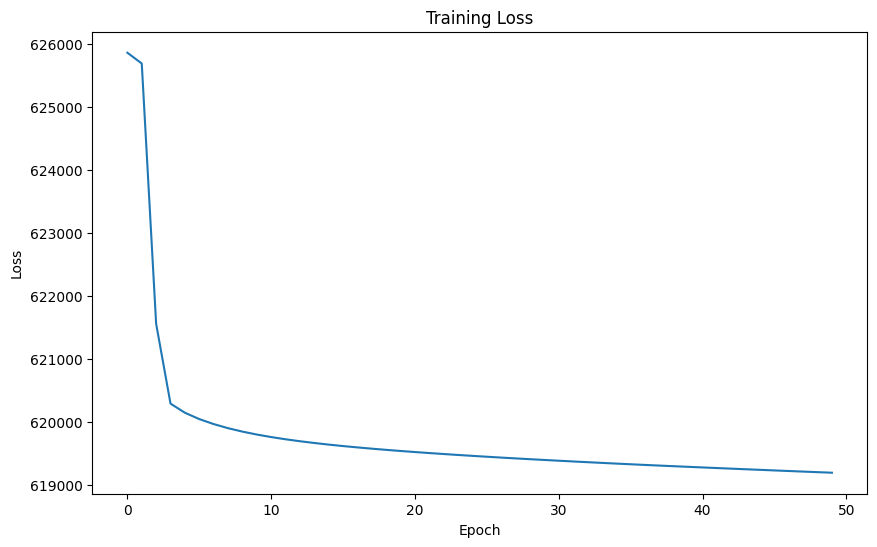

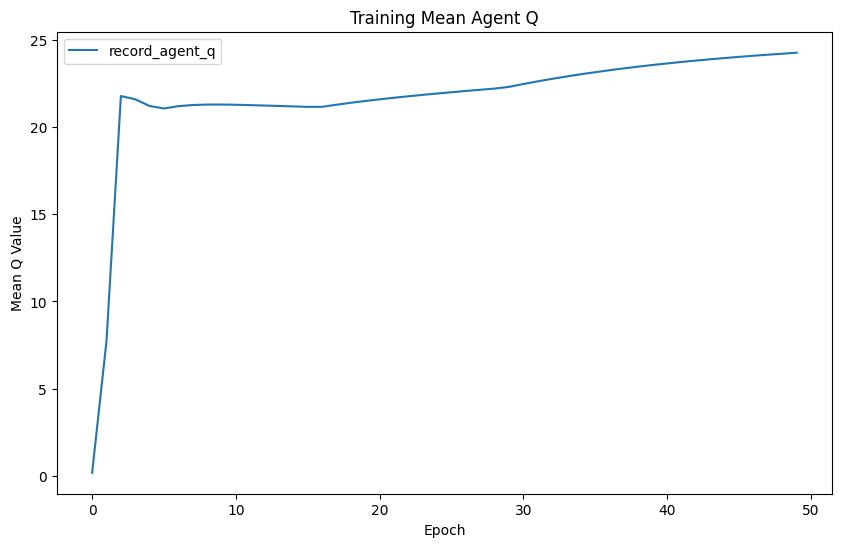

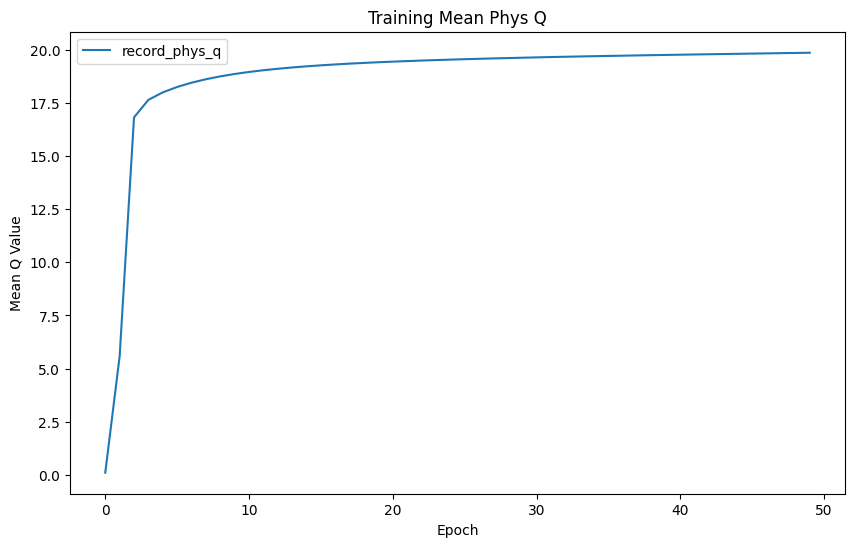

In [20]:
import numpy as np
import matplotlib.pyplot as plt

x_length_list = list(range(len(record_b)))
plt.figure(figsize=(10, 6))
plt.title('Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x_length_list, record_b)
plt.savefig('/content/drive/MyDrive/Capstone/validation_test/training_loss.png', dpi=300, bbox_inches='tight')
np.save('/content/drive/MyDrive/Capstone/validation_test/loss.npy', np.array(record_b))

agent_length_list = list(range(len(record_agent_q)))
record_agent_q_np = [q.detach().cpu().numpy() for q in record_agent_q]
plt.figure(figsize=(10, 6))
plt.title('Training Mean Agent Q')
plt.xlabel("Epoch")
plt.ylabel("Mean Q Value")
plt.plot(agent_length_list, record_agent_q_np, label='record_agent_q')
plt.legend()
plt.savefig('/content/drive/MyDrive/Capstone/validation_test/training_mean_agent_q.png', dpi=300, bbox_inches='tight')
np.save('/content/drive/MyDrive/Capstone/validation_test/mean_agent_q.npy', np.array(record_agent_q_np))

phys_length_list = list(range(len(record_phys_q)))
record_phys_q_np = [q.detach().cpu().numpy() for q in record_phys_q]
plt.figure(figsize=(10, 6))
plt.title('Training Mean Phys Q')
plt.xlabel("Epoch")
plt.ylabel("Mean Q Value")
plt.plot(phys_length_list, record_phys_q_np, label='record_phys_q')
plt.legend()
plt.savefig('/content/drive/MyDrive/Capstone/validation_test/training_mean_phys_q.png', dpi=300, bbox_inches='tight')
np.save('/content/drive/MyDrive/Capstone/validation_test/mean_phys_q.npy', np.array(record_phys_q_np))

# =================测试集，评估test set================================================================
Y90_test = reformat5[test, outcome]
SOFA_test = reformat5[test, 57]
do_test(model, Xtest, actionbloctest, bloctest, Y90_test, SOFA_test, reward_value, beta)

# Plot Survival Rate

In [21]:
from torchsummary import summary

In [22]:
def my_zscore(x):
    return zscore(x, ddof=1), np.mean(x, axis=0), np.std(x, axis=0, ddof=1)

def sliding_mean(data_array, window=1):
    new_list = []
    for i in range(len(data_array)):
        indices = range(max(i - window + 1, 0),
                        min(i + window + 1, len(data_array)))
        avg = 0
        for j in indices:
            avg += data_array[j]
        avg /= float(len(indices))
        new_list.append(avg)
    return np.array(new_list)

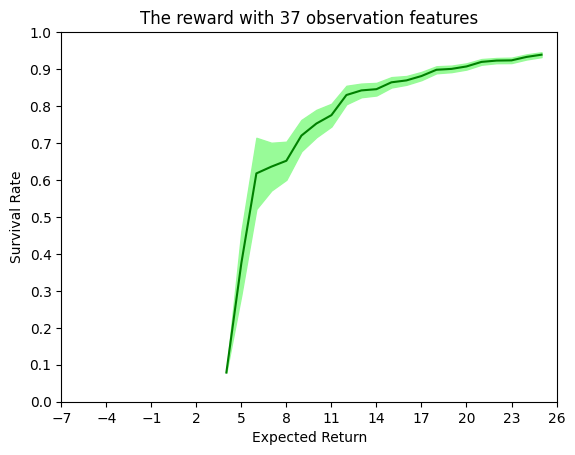

In [23]:
if __name__ == '__main__':
    from scipy.stats import sem

    agent_bQ = np.load('/content/drive/MyDrive/Capstone/Q_value_test/agent_bQ.npy')
    phys_bQ = np.load('/content/drive/MyDrive/Capstone/Q_value_test/phys_bQ.npy')
    shencunlv1 = np.load('/content/drive/MyDrive/Capstone/Q_value_test/shencunlv.npy') # survival rate
    shencunlv = 1 - shencunlv1 # death rate
    agent_b = agent_bQ[:]
    phys_b = phys_bQ[:]

    max_agent_b = max(agent_b)
    min_agent_b = min(agent_b)

    max_phys_b = max(phys_b)
    min_phys_b = min(phys_b)

    bin_medians = []  # %医生的预计汇报中的死亡率，每个人都有一个状态，对应一个Q值，每个Q值大小对应是否死亡
    mort = []
    mort_std = []

    i = -7
    while i <= 25:
        shengcun_bool = (agent_bQ[:] > i - 0.5) & (agent_bQ[:] < i + 0.5)
        count = shencunlv[shengcun_bool == True]
        try:
            res = sum(count) / float(len(count))
            if len(count) >= 2:
                bin_medians.append(i)
                mort.append(res)
                mort_std.append(sem(count))
        except ZeroDivisionError:
            pass
        i += 1
    i = -7
    phys_bin_medians = []
    phys_mort = []
    phys_mort_std = []

    while i <= 8:
        shengcun_bool = (phys_bQ[:] > i - 0.5) & (phys_bQ[:] < i + 0.5)
        count = shencunlv[shengcun_bool == True]

        try:
            res = sum(count) / float(len(count))
            if len(count) >= 2:
                phys_bin_medians.append(i)
                phys_mort.append(res)
                phys_mort_std.append(sem(count))
        except ZeroDivisionError:
            pass
        i += 1

    plt.plot(bin_medians, sliding_mean(mort), color='g')
    plt.fill_between(bin_medians, sliding_mean(mort) - 1 * mort_std,
                     sliding_mean(mort) + 1 * mort_std, color='palegreen')

    x_r = [i / 1.0 for i in range(-7, 27, 3)]
    y_r = [i / 10.0 for i in range(0, 11, 1)]
    plt.xticks(x_r)
    plt.yticks(y_r)

    plt.title('The reward with 37 observation features')
    plt.xlabel("Expected Return")
    plt.ylabel("Survival Rate")

    plt.show()
